<a href="https://colab.research.google.com/github/MahlerTom/Siamese-Neural-Networks/blob/master/IntroToDeepEx02_Chang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

# Clone the entire repo.
!git clone -s git://github.com/MahlerTom/Siamese-Neural-Networks.git Siamese-Neural-Networks
repo_path = os.path.join(os.getcwd(), 'Siamese-Neural-Networks')
train_path = os.path.join(repo_path, 'data', 'train')
test_path = os.path.join(repo_path, 'data', 'test')

fatal: destination path 'Siamese-Neural-Networks' already exists and is not an empty directory.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow==2.0.0-alpha0
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

###Load Data:

Loaded 6685 image paths
##########################################
Printing Example Images



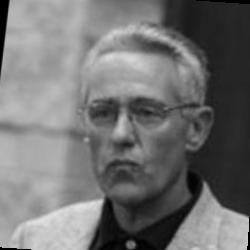

Joseph_Hoy_0001



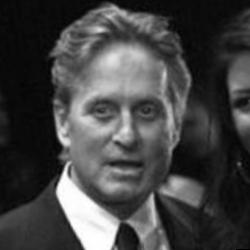

Michael_Douglas_0004



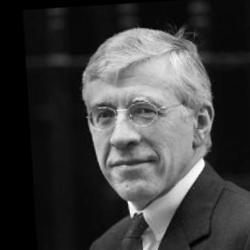

Jack_Straw_0019

##########################################
Loaded 6685 image paths
##########################################
Printing Example Images



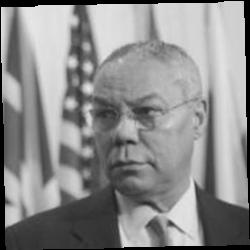

Colin_Powell_0118



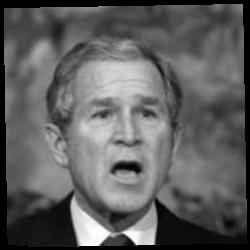

George_W_Bush_0431



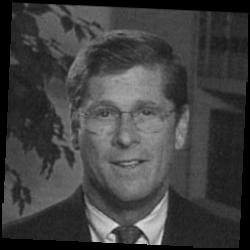

Bill_Simon_0009

##########################################
['Colin_Powell_0004', 'Yang_Jianli_0001', 'Juan_Carlos_Ferrero_0026']
['content/Siamese-Neural-Networks/data/train/Colin_Powell_0004.jpg', 'content/Siamese-Neural-Networks/data/train/Yang_Jianli_0001.jpg', 'content/Siamese-Neural-Networks/data/train/Juan_Carlos_Ferrero_0026.jpg']
[('Aaron_Peirsol_0001', 'Aaron_Peirsol_0002', 1), ('Aaron_Peirsol_0003', 'Aaron_Peirsol_0004', 1), ('Aaron_Sorkin_0001', 'Aaron_Sorkin_0002', 1)]


In [3]:
import pathlib
import random
import IPython.display as display

def load_data(data_path, labels_file, print_imgs=3):
  data_root = pathlib.Path(data_path)
  
  data_paths = list(data_root.glob('*'))
  data_paths = [str(path) for path in data_paths]
  random.shuffle(data_paths)
  data_count = len(data_paths)
  print('Loaded', data_count, 'image paths')
  if print_imgs > 0:
    print('##########################################')
    print('Printing Example Images')
    print()
    
    for n in range(print_imgs):
      image_path = random.choice(data_paths)
      display.display(display.Image(image_path))
      print(image_path.split('/')[-1][:-4])
      print()
      
    print('##########################################')
    
  rel_path = os.path.join(*data_paths[0].split('/')[:-1])
  data_names = [ tip.split('/')[-1][:-4] for tip in data_paths ]
  data_paths_names_dict = { name: os.path.join(rel_path, name + '.jpg') for name in data_names }
    
  labels = list()
  with open(labels_file) as lf:
    for l in lf:
      l = l[:-1].split('\t')
      if len(l) == 3:
        labels.append(tuple((l[0] + '_' + l[1].zfill(4), l[0] + '_' + l[2].zfill(4), 1)))
      if len(l) == 4:
        labels.append(tuple((l[0] + '_' + l[1].zfill(4), l[2] + '_' + l[3].zfill(4), 0)))
        
  return data_paths_names_dict, labels


train_paths_names_dict, train_labels = load_data(train_path, labels_file=os.path.join(repo_path, 'trainPairs.txt'))

test_paths_names_dict, test_labels = load_data(train_path, labels_file=os.path.join(repo_path, 'testPairs.txt'))
print(list(train_paths_names_dict.keys())[:3])
print(list(train_paths_names_dict.values())[:3])
print(train_labels[:3])

In [0]:
train_paths_names_dict

6685

In [0]:
def loadimgs(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

###Import Libararies

In [0]:
import numpy as np
from tensorflow.keras.models import Sequential
import time
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, MaxPooling3D
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

###Build Network

In [0]:
def initialize_bias(shape, name=None, dtype=None):
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)
  
def initialize_weights(shape, name=None, dtype=None):
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)
  
def initialize_weights_dense(shape, name=None, dtype=None):
    return np.random.normal(loc = 0.0, scale = 0.2, size = shape)

In [0]:
def get_siamese_model(input_shape):
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(2048, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights_dense,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [0]:
model = get_siamese_model((250, 250, 1))

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2048)         303186752   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 2048)         0           sequential_1[1][0]           

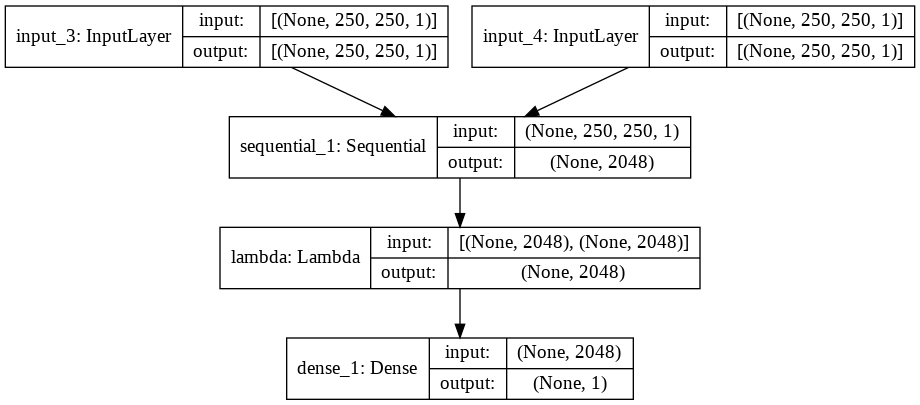

In [35]:
keras.utils.plot_model(model, 'my_first_model_with_shape_info.png', show_shapes=True)